In [154]:
%load_ext autoreload
%autoreload 2
# Enable imports form top-level of project (edit top_level_path accordingly)
import os
import sys
top_level_path = os.path.abspath(os.path.join('..'))
if top_level_path not in sys.path:
	sys.path.append(top_level_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [155]:
from pyqubo import Binary, Array, Num
import numpy as np
from dimod import ExactSolver
import neal
from longestpath import gen_average_degree_directed, gen_planted_path, StandardGraph

import matplotlib.pyplot as plt

In [156]:
lengthss = []
sizes = []
implemented_l = range(2,13)

for outer in implemented_l:
    print(outer)
    # graph = StandardGraph(5, [
    # 	(0,1),
    #     (1,2),
    #     (2,3),
    #     (3,4)
    # ])

    graph = gen_planted_path(outer, 0.5)

    # max length
    N = graph.vertices
    M = outer

    sizes.append(N)

    p = M+1

    matrix = graph.to_matrix()

    vars = Array.create('x', shape=(M+1, N+1), vartype='BINARY')

    import time

    start = time.time()
    serial_exp = Num(-p) * sum([(sum(block) - Num(1))**2 for block in vars]) + Num(0)
    end = time.time()

    #print(f"Done with serial_exp : Took {end - start} seconds")

    #Seems to output same matrix as below
    # serial_exp = Num(0)

    # for m in range(M+1):
    # 	temp_exp = Num(-1)
    # 	for n in range(N+1):
    # 		temp_exp += vars[m][n]
    # 	serial_exp += Num(-p) * temp_exp ** 2

    no_repeat_blocks_exp = Num(0)

    start = time.time()

    for i in range(N):
        #print(f"{i} / {N-1}")
        for j in range(M):

            no_repeat_blocks_exp += sum([vars[j][i] * vars[k][i] for k in range(j+1, M+1)])

    # 		for k in range(j+1, M+1):
    # 			no_repeat_blocks_exp += vars[j][i] * vars[k][i] * Num(-p)
    no_repeat_blocks_exp *= Num(-p)

    end = time.time()

    #print(f"Done with no_repeatblocks_exp : Took {end - start} seconds")

    start = time.time()
    edges_exp = Num(0)
    for m in range(M):
        for i in range(N):
            for j in range(N):
                if i == j:
                    continue
                
                if matrix[i][j]:
                    edges_exp += vars[m][i] * vars[m+1][j]
                else:
                    edges_exp += Num(-p) * vars[m][i] * vars[m+1][j]

    for m in range(M):
        for i in range(N):
            edges_exp += Num(-p) * vars[m][N] * vars[m+1][i]

    end = time.time()

    #print(f"Done with edges_exp : Took {end - start} seconds")

    def to_matrix(exp):
        model = exp.compile()
        qubo, energy_offset = model.to_qubo(index_label=True)

        return np.matrix([[int(qubo.get((i,j), 0)) for j in range((M+1)*(N+1))] for i in range((M+1)*(N+1))])

    total_exp = serial_exp + no_repeat_blocks_exp + edges_exp

    exp = -total_exp

    # print(to_matrix(total_exp))

    start = time.time()

    lengths = []

    for inner in range(10):

        model = exp.compile()
        bqm = model.to_bqm()

        sa = neal.SimulatedAnnealingSampler()
        sampleset = sa.sample(bqm, num_reads=200, num_sweeps=100)
        decoded_samples = model.decode_sampleset(sampleset)
        best_sample = min(decoded_samples, key=lambda x: x.energy)
        #print(best_sample.energy)

        end = time.time()

        #print(f"Solving took {end - start} seconds")

        lengths.append(-best_sample.energy)

    lengthss.append(lengths)

    # sampleset = ExactSolver().sample(bqm)
    # decoded_samples = model.decode_sampleset(sampleset)
    # best_sample = max(decoded_samples, key=lambda s: s.energy)
    # print(best_sample.energy)

#print(sizes)
#print(lengthss)

avarages = [sum(s) / len(s) for s in lengthss]
#print(avarages)
#print(implemented_l)

rel_errors = [((implemented_l[i] - 1) - avarages[i]) / (implemented_l[i] - 1) for i in range(len(avarages))]

per_founds = [((implemented_l[i] - 1) - avarages[i]) / (implemented_l[i] - 1) for i in range(len(avarages))]
#print(rel_errors)


2
3
4
5
6
7
8
9
10
11
12


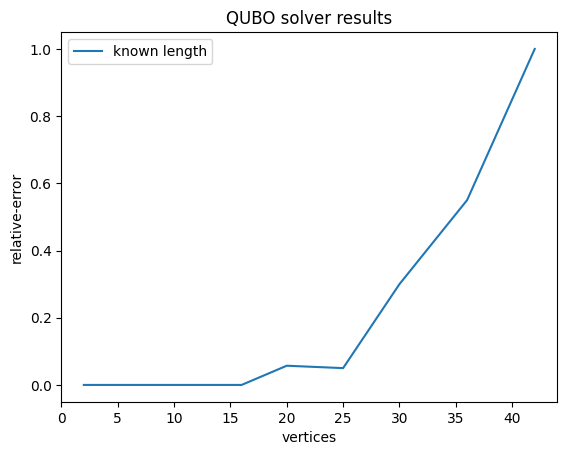

In [157]:
x1 = [i for i in sizes]
y1 = [i for i in rel_errors]

plt.plot(sizes, rel_errors, label = "known length")
plt.title("QUBO solver results")
plt.xlabel("vertices")
plt.ylabel("relative-error")
plt.legend()

In [158]:
lengthss = []
sizes = []
implemented_l = range(2,13)

for outer in implemented_l:
    print(outer)
    # graph = StandardGraph(5, [
    # 	(0,1),
    #     (1,2),
    #     (2,3),
    #     (3,4)
    # ])

    graph = gen_planted_path(outer, 0.5)

    # max length
    N = graph.vertices
    M = N

    sizes.append(N)

    p = M+1

    matrix = graph.to_matrix()

    vars = Array.create('x', shape=(M+1, N+1), vartype='BINARY')

    import time

    start = time.time()
    serial_exp = Num(-p) * sum([(sum(block) - Num(1))**2 for block in vars]) + Num(0)
    end = time.time()

    #print(f"Done with serial_exp : Took {end - start} seconds")

    #Seems to output same matrix as below
    # serial_exp = Num(0)

    # for m in range(M+1):
    # 	temp_exp = Num(-1)
    # 	for n in range(N+1):
    # 		temp_exp += vars[m][n]
    # 	serial_exp += Num(-p) * temp_exp ** 2

    no_repeat_blocks_exp = Num(0)

    start = time.time()

    for i in range(N):
        #print(f"{i} / {N-1}")
        for j in range(M):

            no_repeat_blocks_exp += sum([vars[j][i] * vars[k][i] for k in range(j+1, M+1)])

    # 		for k in range(j+1, M+1):
    # 			no_repeat_blocks_exp += vars[j][i] * vars[k][i] * Num(-p)
    no_repeat_blocks_exp *= Num(-p)

    end = time.time()

    #print(f"Done with no_repeatblocks_exp : Took {end - start} seconds")

    start = time.time()
    edges_exp = Num(0)
    for m in range(M):
        for i in range(N):
            for j in range(N):
                if i == j:
                    continue
                
                if matrix[i][j]:
                    edges_exp += vars[m][i] * vars[m+1][j]
                else:
                    edges_exp += Num(-p) * vars[m][i] * vars[m+1][j]

    for m in range(M):
        for i in range(N):
            edges_exp += Num(-p) * vars[m][N] * vars[m+1][i]

    end = time.time()

    #print(f"Done with edges_exp : Took {end - start} seconds")

    def to_matrix(exp):
        model = exp.compile()
        qubo, energy_offset = model.to_qubo(index_label=True)

        return np.matrix([[int(qubo.get((i,j), 0)) for j in range((M+1)*(N+1))] for i in range((M+1)*(N+1))])

    total_exp = serial_exp + no_repeat_blocks_exp + edges_exp

    exp = -total_exp

    # print(to_matrix(total_exp))

    start = time.time()

    lengths = []

    for inner in range(10):

        model = exp.compile()
        bqm = model.to_bqm()

        sa = neal.SimulatedAnnealingSampler()
        sampleset = sa.sample(bqm, num_reads=200, num_sweeps=100)
        decoded_samples = model.decode_sampleset(sampleset)
        best_sample = min(decoded_samples, key=lambda x: x.energy)
        #print(best_sample.energy)

        end = time.time()

        #print(f"Solving took {end - start} seconds")

        lengths.append(-best_sample.energy)

    lengthss.append(lengths)

    # sampleset = ExactSolver().sample(bqm)
    # decoded_samples = model.decode_sampleset(sampleset)
    # best_sample = max(decoded_samples, key=lambda s: s.energy)
    # print(best_sample.energy)

#print(sizes)
#print(lengthss)

avarages = [sum(s) / len(s) for s in lengthss]
#print(avarages)
#print(implemented_l)

rel_errors = [((implemented_l[i] - 1) - avarages[i]) / (implemented_l[i] - 1) for i in range(len(avarages))]

per_founds = [((implemented_l[i] - 1) - avarages[i]) / (implemented_l[i] - 1) for i in range(len(avarages))]
#print(rel_errors)


2
3
4
5
6
7
8
9
10
11
12


In [169]:
avarages = []
for s in lengthss:
    t1 = []
    t2 = 0.0
    for val in s:
        print(s)
        if val >= 0:
            t1.append(val)
            t2 += 1
    if t2 > 0:
        avarages.append(sum(t1) / t2)
    else:
        avarages.append(9999)

x2 =[]
y2 = []

rel_errors = []

print(avarages)

j = 0
for i in range(len(sizes)):
    if avarages[i] != 9999:
        x2.append(sizes[i])
        y2.append((implemented_l[i] - 1) - avarages[j]) / (implemented_l[i] - 1)
        j += 1
    

plt.plot(x2, y2, label = "No knowledge on length")
plt.plot(x1, y1, label = "Known length")

plt.title("QUBO solver : Knowledge on length")
plt.xlabel("vertices")
plt.ylabel("relative-error")
plt.legend()

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]
[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]
[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]
[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]
[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]
[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]
[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]
[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]
[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0]
[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 

TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'